<a href="https://colab.research.google.com/github/MohamadHBaydoun/COMP9444/blob/MohamadBranch/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MohamadHBaydoun/COMP9444.git

Cloning into 'COMP9444'...
remote: Enumerating objects: 3469, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 3469 (delta 1), reused 0 (delta 0), pack-reused 3463 (from 1)
Receiving objects: 100% (3469/3469), 2.48 GiB | 39.85 MiB/s, done.
Resolving deltas: 100% (400/400), done.
Updating files: 100% (3835/3835), done.


In [2]:
# 0. Import packages
import os
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [49]:
# 1. Create model


# USE RESIDUAL NEURAL NETWORKS AND FCN'S WITH 1X1 CONVOLUTIONS AND UPSAMPLING OPERATIONS
import torch

class CustomFCN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(CustomFCN, self).__init__()

        # Downsampling (Encoder)
        self.enc1 = self.conv_chain(in_channels, 3, 3, 8, 1, 1)
        self.pool1 = nn.MaxPool2d(2, stride=2)

        self.enc2 = self.conv_chain(8, 3, 3, 16, 1, 1)
        self.pool2 = nn.MaxPool2d(2, stride=2)

        self.enc3 = self.conv_chain(16, 3, 3, 32, 1, 1)
        self.pool3 = nn.MaxPool2d(2, stride=2)

       # Upsampling (Decoder)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv_chain(32, 3, 3, 16, 1, 1)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = self.conv_chain(16, 3, 3, 8, 1, 1)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = self.conv_chain(8, 3, 3, 1, 1, 1)

    def conv_chain(self, Din, L, M, D, S, P):
      return nn.Sequential(
          nn.Conv2d(in_channels=Din, out_channels=D, kernel_size=(L, M), padding=P, stride=S),
          nn.ReLU(inplace=True)
      )

    def forward(self, x):
        # Encoder
        x1 = self.iterative_forward(x, self.pool1, self.enc1)
        x2 = self.iterative_forward(x1, self.pool2, self.enc2)
        x3 = self.iterative_forward(x2, self.pool3, self.enc3)

        # Decoder
        y = self.up1(x3)
        y = self.dec1(y)
        y = y + x2

        y = self.up2(y)
        y = self.dec2(y)
        y = y + x1

        y = self.up3(y)
        y = self.dec3(y)

        return y

    def iterative_forward(self, x, poolFunc, encFunc):
        # Encoder
        xNew = poolFunc(encFunc(x))
        for i in range(7):
          xNew = poolFunc(encFunc(xNew))
        return xNew

# Create model instance
model = CustomFCN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)


CustomFCN(
  (enc1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up1): Upsample(scale_factor=2.0, mode='bilinear')
  (dec1): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (up2): Upsample(scale_factor=2.0, mode='bilinear')
  (dec2): Sequential(
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(in

In [5]:
# 2. Prepare data
IMAGE_PATH = "./COMP9444/filtered_image"
LABEL_PATH = "./COMP9444/filtered_label"

trainFiles = pd.read_csv("./COMP9444/train.csv", header=None)[0].tolist()[:250]
testFiles = pd.read_csv("./COMP9444/test.csv", header=None)[0].tolist()[:250]


def load_image(path):
    """Load an RGB image and convert to a tensor"""
    img = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((480, 640)),  # Resize images
        transforms.ToTensor(),  # Convert to tensor
        transforms.Grayscale(num_output_channels=1)
    ])
    return transform(img)  # Apply transform

class QuakeCityDataset(torch.utils.data.Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        img = load_image(os.path.join(IMAGE_PATH, filename))
        # component = load_annotation("component", filename)
        crack = load_image(os.path.join(LABEL_PATH, "crack", filename))
        # spall = load_annotation("spall", filename)
        # rebar = load_annotation("rebar", filename)
        # ds = load_annotation("ds", filename)
        # depth = load_annotation("depth", filename)
        label = crack
        return img, label

# Create dataset and dataloader
train_dataset = QuakeCityDataset(trainFiles)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)

# Get a batch
img_batch, label_batch = next(iter(train_loader))
print("Batch image shape:", img_batch.shape)
print("Batch label shape:", label_batch.shape)


Batch image shape: torch.Size([5, 1, 480, 640])
Batch label shape: torch.Size([5, 1, 480, 640])


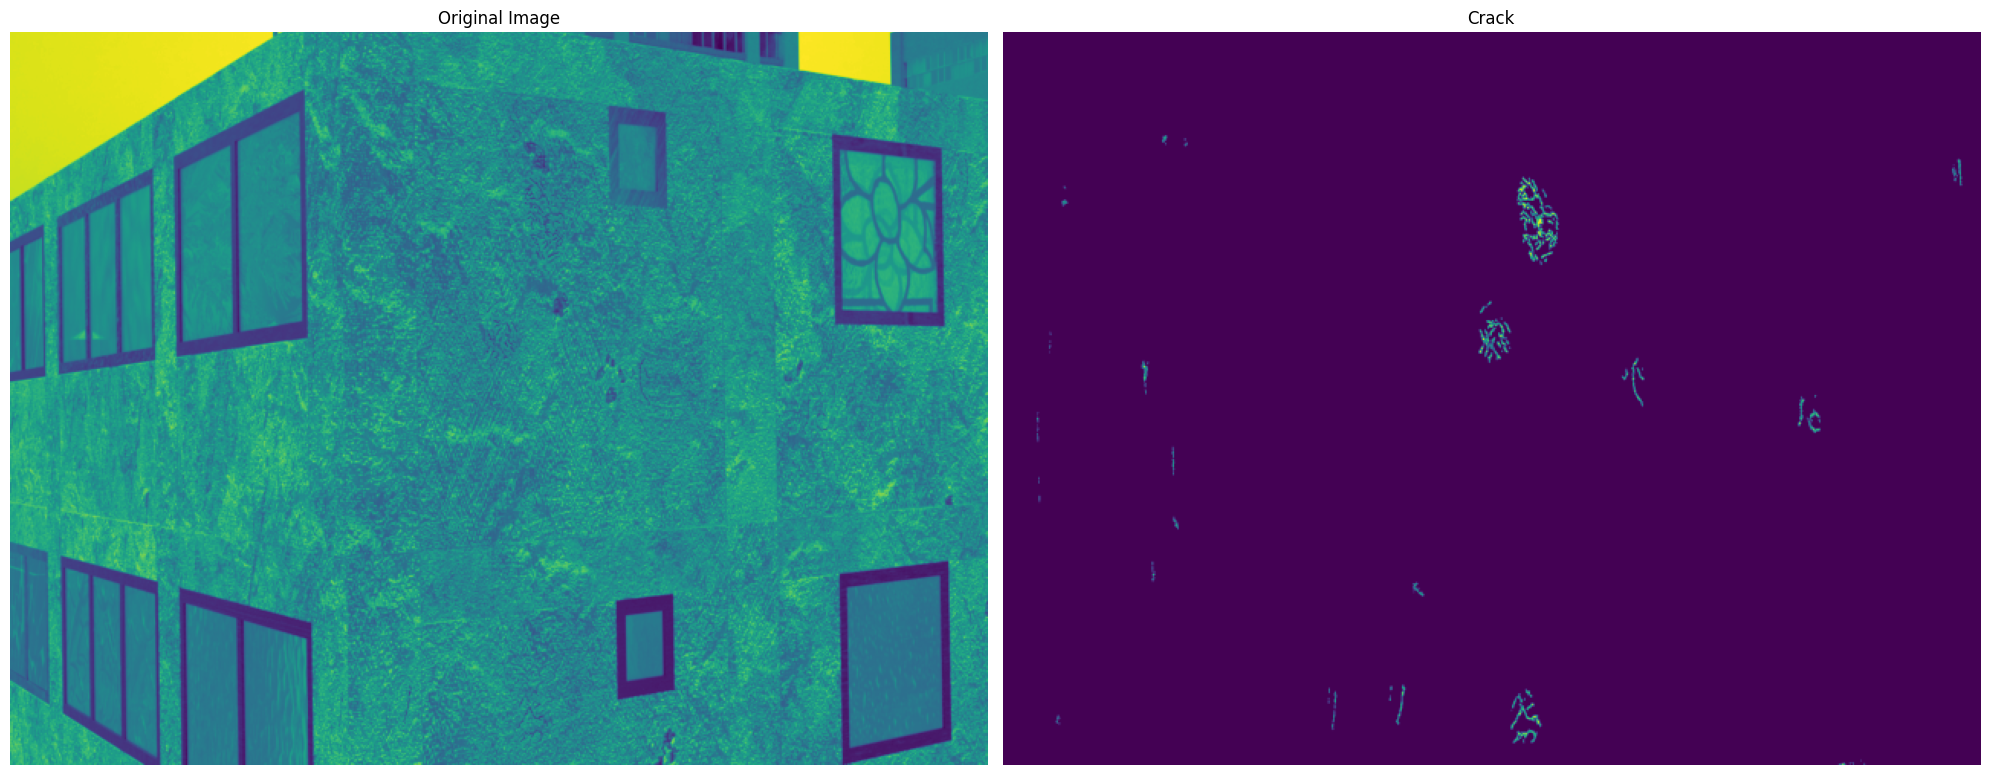

In [8]:
# 2.5 Visualise data
def visualize_sample(image, label):
    """Display the image and its 6 label masks."""
    label_names = ["Component", "Crack", "Spall", "Rebar", "Damage State", "Depth"]
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Show the original image
    axes[0].imshow(image.permute(1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    # Show the label mask
    axes[1].imshow(label.permute(1, 2, 0))  # Visualize label
    axes[1].set_title(label_names[1])
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

img_batch, label_batch = next(iter(train_loader))
visualize_sample(img_batch[0], label_batch[0])

In [63]:
# 3. Choose optimizer

criterion = nn.BCEWithLogitsLoss()  # Multi-class segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0003


<ipython-input-64-180cf07bdbc4>:25: RuntimeWarning: invalid value encountered in divide
  output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())


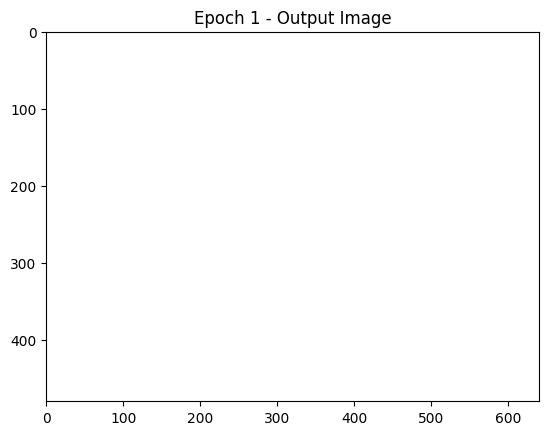

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0010


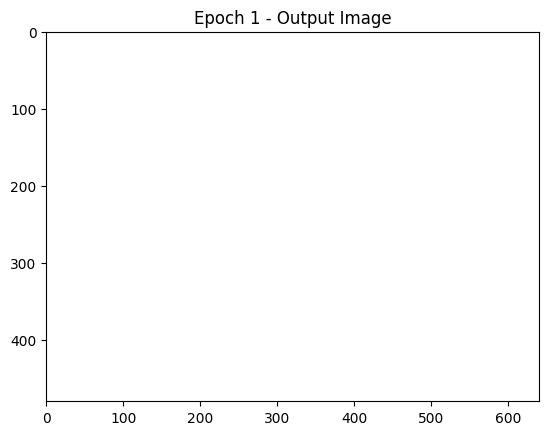

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0008


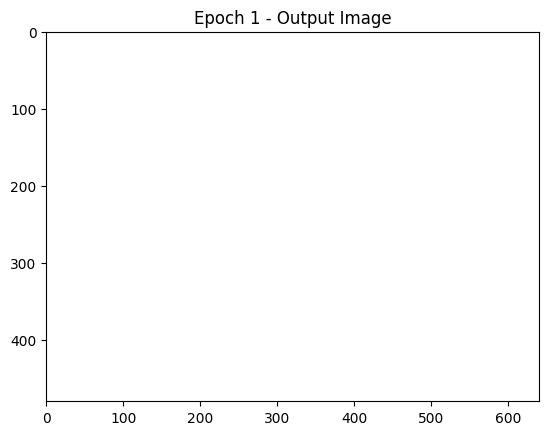

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0008


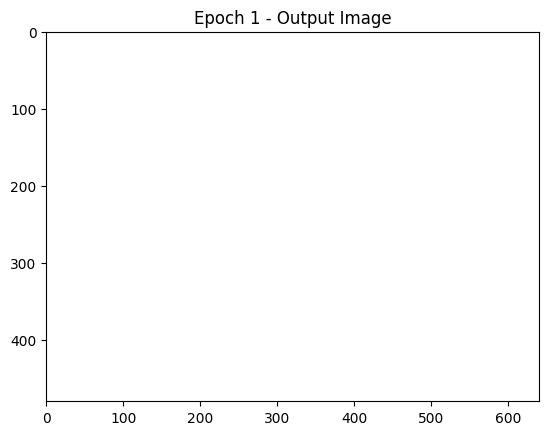

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0012


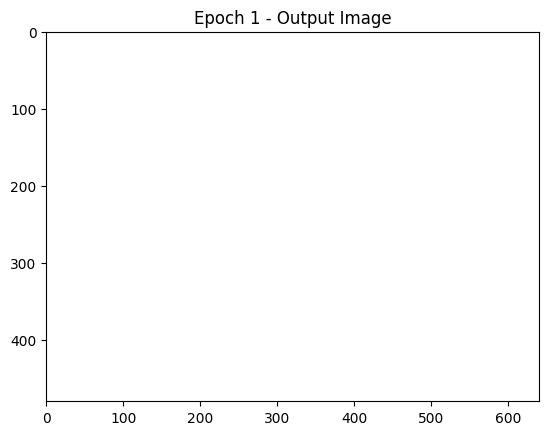

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0004


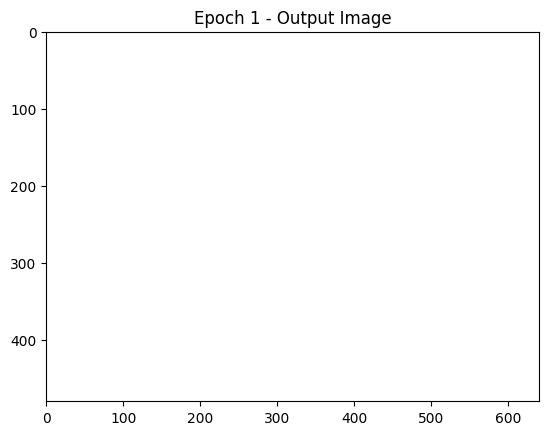

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0007


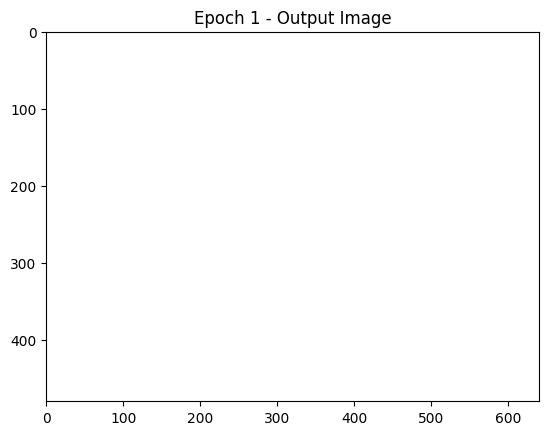

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0010


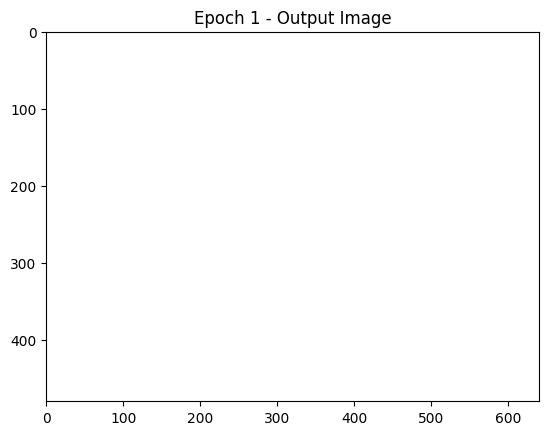

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0007


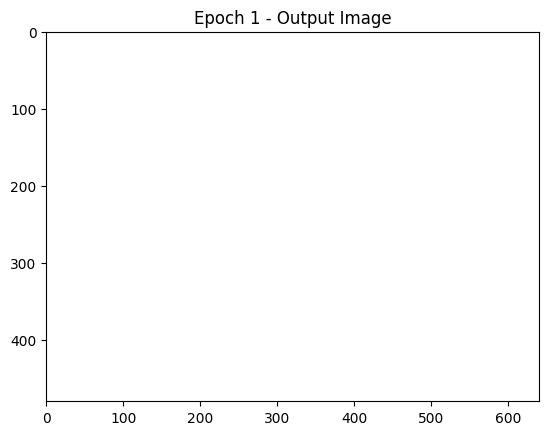

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0003


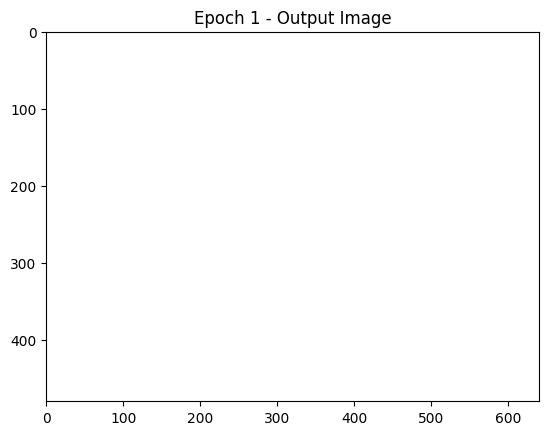

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0007


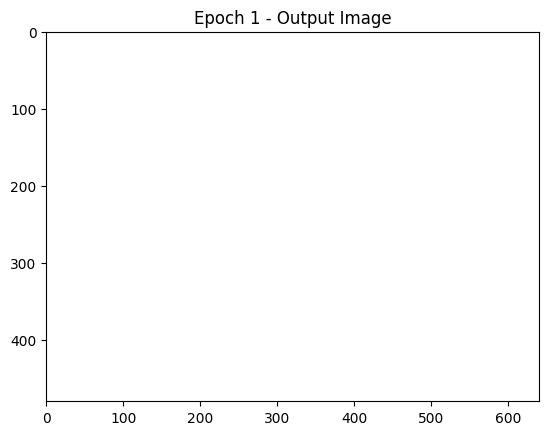

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0020


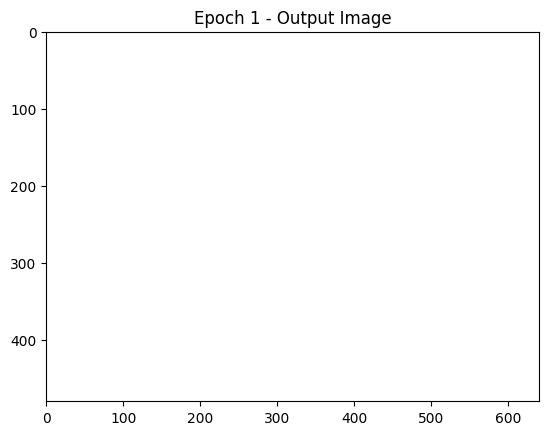

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0016


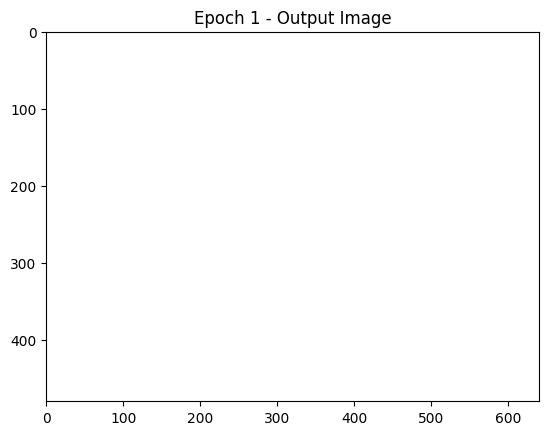

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0005


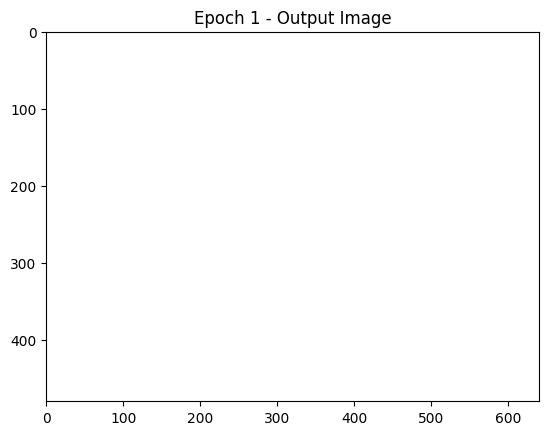

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0009


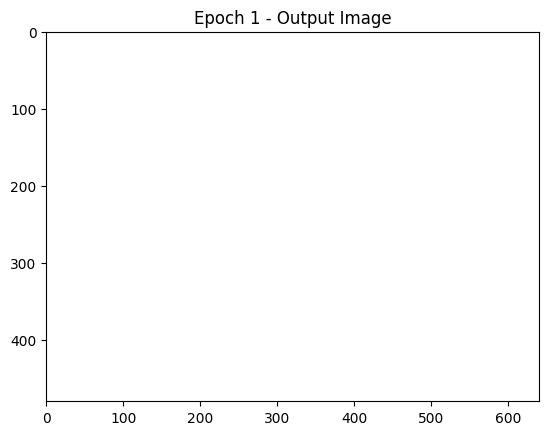

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0006


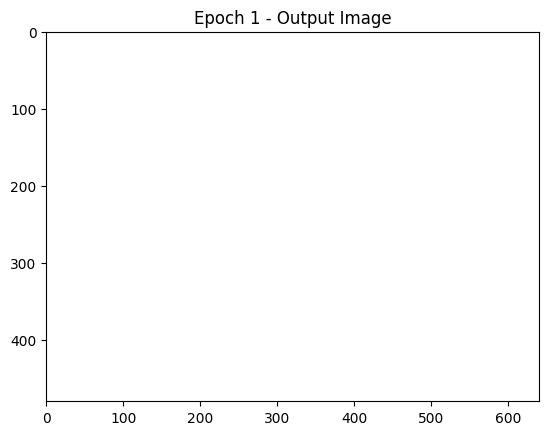

torch.Size([5, 1, 480, 640])
Epoch  1: zero_grad(): loss= 0.6931 output_mean= 0.0000 target_mean= 0.0005


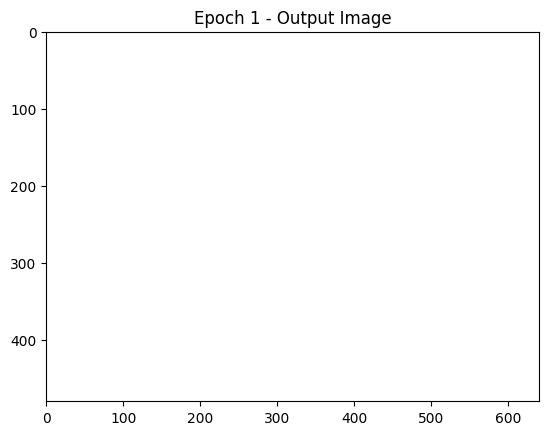

KeyboardInterrupt: 

In [64]:
# 4. Train model

epochs = 2

for epoch in range(1, epochs):

    for batch_id, (data,target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad() # zero the gradients
        output = model(data)    # apply network (Same as model.forward(data))
        print(output.shape)
        loss = criterion(output, target)

        loss.backward()       # compute gradients
        optimizer.step()      # update weights

         # Print loss and statistics of output/target
        print('Epoch%3d: zero_grad(): loss=%7.4f output_mean=%7.4f target_mean=%7.4f' %
              (epoch, loss.item(), output.mean().item(), target.mean().item()))

        # Convert the output tensor to a NumPy array and plot the image
        output_image = output[-1].cpu().detach().numpy()  # Get the first image in the batch
        output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())

        # Convert from (C, H, W) to (H, W, C)
        output_image = np.transpose(output_image, (1, 2, 0))

        # Clip values to [0, 1] range (in case of any rounding issues)
        output_image = np.clip(output_image, 0, 1)

        # Display the output image (for visualization)
        plt.imshow(output_image)
        plt.title(f"Epoch {epoch} - Output Image")
        plt.show()

F1 Score: 0.0
Confusion matrix, without normalization
[[76800000        0]
 [       0        0]]


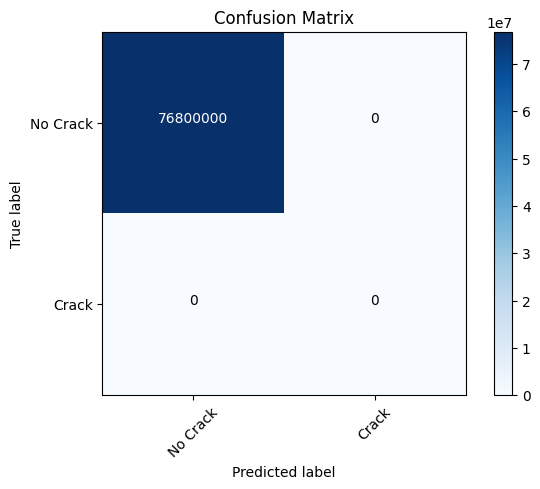

In [58]:
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np

def calculate_f1_and_confusion_matrix(model, dataloader, device):
    """
    Calculates the F1 score and confusion matrix for a given model and dataloader.

    Args:
        model: The trained PyTorch model.
        dataloader: The DataLoader for the dataset.
        device: The device (CPU or GPU) to use.

    Returns:
        f1_score: The calculated F1 score.
        confusion_matrix: The confusion matrix as a NumPy array.
    """

    # Initialize metrics
    f1 = torchmetrics.F1Score(task="binary", num_classes=2).to(device) # Assuming binary classification
    confusion_matrix = torchmetrics.ConfusionMatrix(task="binary", num_classes=2).to(device)

    # Iterate over the dataloader
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Apply sigmoid to get probabilities (if using BCEWithLogitsLoss)
            output = torch.sigmoid(output)

            # Threshold predictions to get binary values
            predicted_labels = (output > 0.5).int()

            # Update metrics
            f1.update(predicted_labels, target.int())
            confusion_matrix.update(predicted_labels, target.int())

    # Compute and return the final metrics
    f1_score = f1.compute().item()
    confusion_matrix = confusion_matrix.compute().cpu().numpy()

    return f1_score, confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Plots the confusion matrix.

    Args:
        cm: The confusion matrix as a NumPy array.
        classes: A list of class names.
        normalize: If True, normalize the confusion matrix.
        title: The title of the plot.
        cmap: The colormap to use.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Calculate and display F1 score and confusion matrix
f1_score, confusion_matrix = calculate_f1_and_confusion_matrix(model, train_loader, device)
print(f"F1 Score: {f1_score}")

# Plot the confusion matrix
class_names = ['No Crack', 'Crack']  # Replace with your class names
plot_confusion_matrix(confusion_matrix, classes=class_names, title='Confusion Matrix')